In [2]:
import csv
from RDFunctions import *
# Go to each of 912 records
# Get SI series for each record using each method
# Then select a threshold and see sensitivity, specificity and lead time and penalized lead time for each

In [3]:
def getSIseries(serial_id,dfOuranno,method,model):
    OUTLIERSD = 2.5
    LOWESSWINDOW = 3.0
    record_name = dfOuranno.loc[serial_id,'RecordNum'] 
    patient_id = dfOuranno.loc[serial_id,'PatientId']
    flname = './FinalRecords/'+str(record_name)+'n.hea'
    recname = './FinalRecords/'+str(record_name)+'n'       
    
    [samples,R,S,H,firstline] = getIndexOfRRSpO2HR(flname)
    rec =  wfdb.io.rdrecord(str(recname))
    xrr = rec.p_signal[:,R]
    xspo2 = rec.p_signal[:,S]
    xhr = rec.p_signal[:,H]
    TOTAL_LEN = len(xrr)
    t = np.arange(0,TOTAL_LEN,1)
    
    [xrrnew,trrnew] = outlierRejector(xrr,t,OUTLIERSD,default=15.0)
    [xspo2new,tspo2new] = outlierRejector(xspo2,t,OUTLIERSD, default=98.0)
    [xhrnew,thrnew] = outlierRejector(xhr,t,OUTLIERSD)
    
    zrrnew = applyLowess(xrrnew,trrnew,LOWESSWINDOW*60)
    zspo2new = applyLowess(xspo2new,tspo2new,LOWESSWINDOW*60)
    zhrnew = applyLowess(xhrnew,thrnew,LOWESSWINDOW*60)
    
    tnew = zrrnew[:,0]/60.0
    
    rr_loess = zrrnew[:,1]
    spo2_loess = zspo2new[:,1]
        
    bar_h = []
    
    if(method=='LR' or method=='LGB' or method=='MLP' or method=='SVM'):
        for ii in range(24*60,TOTAL_LEN,60):
            feature_array = getLongFeatures(rr_loess[(ii-24*60):ii],spo2_loess[(ii-24*60):ii])
            feature_array = np.array(feature_array[0:12],dtype=np.float32)
            predict = model.predict_proba(feature_array.reshape(1,-1))[0][1]
            bar_h.append(predict)
            
    if(method=='CNN' or method=='LSTM'):
        seg = np.zeros((1,1440,2),dtype=np.float64)
        for ii in range(24*60,TOTAL_LEN,60):
            seg[0,:,0] = (rr_loess[(ii-24*60):ii] - 25)/10
            seg[0,:,1] = (spo2_loess[(ii-24*60):ii] - 93)/10
            predict = model.predict(seg)[0,0]
            bar_h.append(predict)
        
    return bar_h

In [4]:
import pickle
annofile = r'RecordsAnno4.csv'
dfOuranno = pd.read_csv(annofile, encoding='iso-8859-1')  

In [ ]:
# load logistic regression model from disk
LR_model = pickle.load(open('logistic_model.sav', 'rb'))

SIsequences = []
for i in range(len(dfOuranno)):
    print(i,end=" ")
    SIsequences.append(getSIseries(i,dfOuranno,"LR",LR_model))
    
with open("LR_seqs.csv", "w", newline="") as f:
    writer = csv.writer(f)
    writer.writerows(SIsequences)

In [4]:
dfx = pd.read_csv('AlarmsInfo.csv',sep=',')
print(np.shape(dfx))
dfx.head()

(912, 16)


,RecordNum,PatientId,ICUStayId,Duration,Category,nRRraw,nRRfilt,nSpO2raw,nSpO2filt,nRD,fRR_b24,fRR_a24,fSP_b24,fSP_a24,fRD,Lead
0,3887555,79,290076,38.200000,D,12,0,23,1,0,NaN,NaN,11.433333,NaN,NaN,NaN
1,3647298,85,291697,45.316667,B,191,1,8,0,0,1.0,NaN,NaN,NaN,NaN,NaN
2,3485814,123,227264,34.000000,C,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
3,3991520,124,255660,53.016667,F,0,0,1,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,3807277,124,255660,32.316667,F,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
def analyseRDAlarmThresh(RDSeqfile):
    f = open(RDSeqfile, "r")
    dfx = pd.read_csv('AlarmsInfo.csv',sep=',')
    for thresh in np.arange(0.1,1.0,0.1):
        print("------thres=%f----------"%thresh)
        l = f.readline().strip()
        i = 0
        TP = TN = P = N = 0
        while(l):
            z = [float(y) for y in l.split(",")]
            nAlarms = int(dfx.loc[i,'nRRfilt']) + int(dfx.loc[i,'nSpO2filt'])
            if(nAlarms>0):
                P+=1
            if(nAlarms==0):
                N+=1

            RDAlarms = [float(ind)+24.0 for ind in range(len(z)) if z[ind]>=thresh]
            nRDAlarms = len(RDAlarms)

            if(nAlarms>0 and nRDAlarms>0):
                TP+=1
            if(nAlarms==0 and nRDAlarms==0):
                TN+=1
            i+=1
            l = f.readline().strip()

        print('Positive : ' + str(P))
        print('True Positive : ' + str(TP))
        print('Negative : ' + str(N))
        print('True Negative : ' + str(TN))
        sens = float(TP)/P
        spec = float(TN)/N
        print('Sensitivity :'+str(sens))
        print('Specificity :'+str(spec))
        print("Check threshold effectiveness : " + str(sens-(1-spec)))
        f.seek(0)


In [6]:
# Create variable ffA (first filtered Alarm if it occurs after 24 hours)
# Put the earliest of RR or SpO2 filtered after 24 alarm
# If no alarm after 24.0 put NaN
# If RDAlarm there then put the earliest one if not put NaN in fRD
# Now calculate the lead time and penalized lead time
import matplotlib.pyplot as plt
import matplotlib

def leadTimeAnalysis(RDSeqfile,thresh):
    f = open(RDSeqfile, "r")
    dfx = pd.read_csv('AlarmsInfo.csv',sep=',')
    l = f.readline().strip()
    i = 0
    penLeadArr = []
    leadArr = []
    while(l):
        ffA = np.nanmin([dfx.loc[i,"fRR_a24"], dfx.loc[i,"fSP_a24"]])
        fRD = np.NaN

        z = [float(y) for y in l.split(",")]
        RDAlarms = [float(ind)+24.0 for ind in range(len(z)) if z[ind]>=thresh]
        nRDAlarms = len(RDAlarms)
        if(nRDAlarms>0):
            fRD = min(RDAlarms)

        if((not np.isnan(ffA)) and (not np.isnan(fRD))):
            #print(str(ffA) + "  " + str(fRD))
            lead = ffA - fRD
            #print(lead)
            penLeadArr.append(lead)
            if(lead>0):
                leadArr.append(lead)
        i+=1
        l = f.readline().strip()

    print(len(leadArr))
    print(len(penLeadArr))
    print(sum(leadArr)/len(leadArr))
    print(sum(penLeadArr)/len(penLeadArr))
    # An "interface" to matplotlib.axes.Axes.hist() method
    n, bins, patches = plt.hist(x=penLeadArr, bins=[-40,-5,0,1,6,12,24,96], color='#0504aa', alpha=0.7, rwidth=0.85)
    plt.grid(axis='y', alpha=0.75)
    font = {'size': 9, 'weight':'bold'}
    matplotlib.rc('font', **font)
    plt.xlabel('Lead(Hours)',fontdict={'fontsize': 13})
    plt.ylabel('Frequency',fontdict={'fontsize': 13})
    plt.title('Histogram of Penalized Lead Time',fontdict={'fontsize': 13})
    #plt.text(23, 225, r'$\mu=3.56$ hours')
    maxfreq = n.max()
    # Set a clean upper y-axis limit.
    plt.ylim(ymax=100)

In [8]:
analyseRDAlarmThresh("LR_seqs.csv")

------thres=0.100000----------
Positive : 452
True Positive : 451
Negative : 460
True Negative : 102
Sensitivity :0.9977876106194691
Specificity :0.2217391304347826
Check threshold effectiveness : 0.21952674105425174
------thres=0.200000----------
Positive : 452
True Positive : 447
Negative : 460
True Negative : 179
Sensitivity :0.9889380530973452
Specificity :0.38913043478260867
Check threshold effectiveness : 0.37806848787995384
------thres=0.300000----------
Positive : 452
True Positive : 441
Negative : 460
True Negative : 227
Sensitivity :0.9756637168141593
Specificity :0.4934782608695652
Check threshold effectiveness : 0.46914197768372445
------thres=0.400000----------
Positive : 452
True Positive : 437
Negative : 460
True Negative : 253
Sensitivity :0.9668141592920354
Specificity :0.55
Check threshold effectiveness : 0.5168141592920354
------thres=0.500000----------
Positive : 452
True Positive : 430
Negative : 460
True Negative : 283
Sensitivity :0.9513274336283186
Specificity :

/home/ubuntu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: All-NaN axis encountered


185
243
9.790270270270264
5.3676268861454


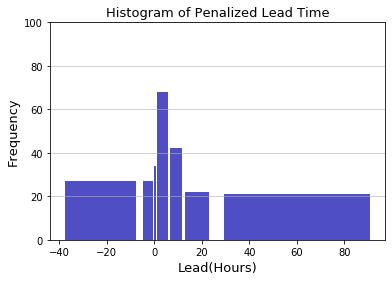

In [9]:
leadTimeAnalysis("LR_seqs.csv",thresh=0.8)

In [11]:
from tqdm.notebook import tqdm
# load lgb model from disk
LGB_model = pickle.load(open('lgb_model.sav', 'rb'))

SIsequences = []
for i in tqdm(range(len(dfOuranno))):
    #print(i,end=" ")
    SIsequences.append(getSIseries(i,dfOuranno,"LGB",LGB_model))
    
with open("LGB_seqs.csv", "w", newline="") as f:
    writer = csv.writer(f)
    writer.writerows(SIsequences)

In [12]:
analyseRDAlarmThresh("LGB_seqs.csv")

------thres=0.100000----------
Positive : 452
True Positive : 447
Negative : 460
True Negative : 181
Sensitivity :0.9889380530973452
Specificity :0.3934782608695652
Check threshold effectiveness : 0.38241631396691045
------thres=0.200000----------
Positive : 452
True Positive : 447
Negative : 460
True Negative : 227
Sensitivity :0.9889380530973452
Specificity :0.4934782608695652
Check threshold effectiveness : 0.4824163139669103
------thres=0.300000----------
Positive : 452
True Positive : 441
Negative : 460
True Negative : 252
Sensitivity :0.9756637168141593
Specificity :0.5478260869565217
Check threshold effectiveness : 0.523489803770681
------thres=0.400000----------
Positive : 452
True Positive : 435
Negative : 460
True Negative : 275
Sensitivity :0.9623893805309734
Specificity :0.5978260869565217
Check threshold effectiveness : 0.5602154674874952
------thres=0.500000----------
Positive : 452
True Positive : 434
Negative : 460
True Negative : 286
Sensitivity :0.9601769911504425
Spe

/home/ubuntu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: All-NaN axis encountered


186
251
9.862724014336912
5.552456839309425


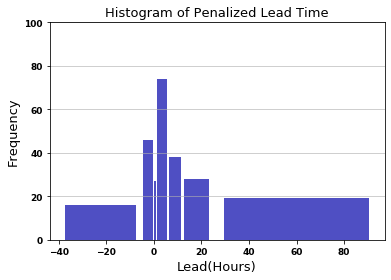

In [13]:
leadTimeAnalysis("LGB_seqs.csv",thresh=0.9)

In [14]:
from tqdm.notebook import tqdm
# load mlp model from disk
MLP_model = pickle.load(open('mlp_model.sav', 'rb'))

SIsequences = []
for i in tqdm(range(len(dfOuranno))):
    #print(i,end=" ")
    SIsequences.append(getSIseries(i,dfOuranno,"MLP",MLP_model))
    
with open("MLP_seqs.csv", "w", newline="") as f:
    writer = csv.writer(f)
    writer.writerows(SIsequences)

In [15]:
analyseRDAlarmThresh("MLP_seqs.csv")

------thres=0.100000----------
Positive : 452
True Positive : 437
Negative : 460
True Negative : 224
Sensitivity :0.9668141592920354
Specificity :0.48695652173913045
Check threshold effectiveness : 0.4537706810311659
------thres=0.200000----------
Positive : 452
True Positive : 435
Negative : 460
True Negative : 254
Sensitivity :0.9623893805309734
Specificity :0.5521739130434783
Check threshold effectiveness : 0.5145632935744517
------thres=0.300000----------
Positive : 452
True Positive : 431
Negative : 460
True Negative : 281
Sensitivity :0.9535398230088495
Specificity :0.6108695652173913
Check threshold effectiveness : 0.5644093882262409
------thres=0.400000----------
Positive : 452
True Positive : 426
Negative : 460
True Negative : 301
Sensitivity :0.9424778761061947
Specificity :0.6543478260869565
Check threshold effectiveness : 0.5968257021931512
------thres=0.500000----------
Positive : 452
True Positive : 423
Negative : 460
True Negative : 311
Sensitivity :0.9358407079646017
Sp

/home/ubuntu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: All-NaN axis encountered


215
259
9.91201550387597
7.098906048906046


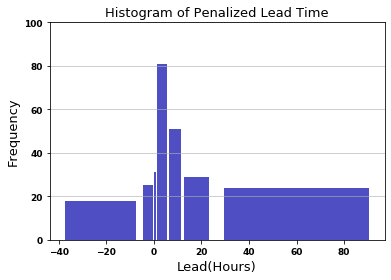

In [16]:
leadTimeAnalysis("MLP_seqs.csv",thresh=0.7)

In [17]:
from tqdm.notebook import tqdm
# load svm model from disk
SVM_model = pickle.load(open('svm_model.sav', 'rb'))

SIsequences = []
for i in tqdm(range(len(dfOuranno))):
    #print(i,end=" ")
    SIsequences.append(getSIseries(i,dfOuranno,"SVM",SVM_model))
    
with open("SVM_seqs.csv", "w", newline="") as f:
    writer = csv.writer(f)
    writer.writerows(SIsequences)


In [7]:
analyseRDAlarmThresh("SVM_seqs.csv")

------thres=0.100000----------
Positive : 452
True Positive : 446
Negative : 460
True Negative : 187
Sensitivity :0.9867256637168141
Specificity :0.40652173913043477
Check threshold effectiveness : 0.3932474028472489
------thres=0.200000----------
Positive : 452
True Positive : 442
Negative : 460
True Negative : 229
Sensitivity :0.9778761061946902
Specificity :0.49782608695652175
Check threshold effectiveness : 0.475702193151212
------thres=0.300000----------
Positive : 452
True Positive : 437
Negative : 460
True Negative : 253
Sensitivity :0.9668141592920354
Specificity :0.55
Check threshold effectiveness : 0.5168141592920354
------thres=0.400000----------
Positive : 452
True Positive : 434
Negative : 460
True Negative : 265
Sensitivity :0.9601769911504425
Specificity :0.5760869565217391
Check threshold effectiveness : 0.5362639476721817
------thres=0.500000----------
Positive : 452
True Positive : 434
Negative : 460
True Negative : 283
Sensitivity :0.9601769911504425
Specificity :0.6

/home/ubuntu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: All-NaN axis encountered


219
265
10.751445966514462
8.032201257861633


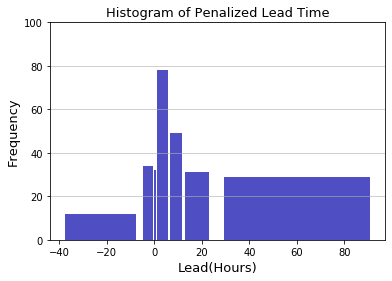

In [8]:
leadTimeAnalysis("SVM_seqs.csv",thresh=0.8)

In [9]:
from tqdm.notebook import tqdm
import tensorflow.keras as ks

# load CNN model from disk
CNN_model = ks.models.load_model('QuantCNN.h5')

SIsequences = []
for i in tqdm(range(len(dfOuranno))):
    #print(i,end=" ")
    SIsequences.append(getSIseries(i,dfOuranno,"CNN",CNN_model))
    
with open("CNN_seqs.csv", "w", newline="") as f:
    writer = csv.writer(f)
    writer.writerows(SIsequences)


In [10]:
analyseRDAlarmThresh("CNN_seqs.csv")

------thres=0.100000----------
Positive : 452
True Positive : 451
Negative : 460
True Negative : 55
Sensitivity :0.9977876106194691
Specificity :0.11956521739130435
Check threshold effectiveness : 0.1173528280107734
------thres=0.200000----------
Positive : 452
True Positive : 446
Negative : 460
True Negative : 153
Sensitivity :0.9867256637168141
Specificity :0.33260869565217394
Check threshold effectiveness : 0.319334359368988
------thres=0.300000----------
Positive : 452
True Positive : 440
Negative : 460
True Negative : 231
Sensitivity :0.9734513274336283
Specificity :0.5021739130434782
Check threshold effectiveness : 0.4756252404771065
------thres=0.400000----------
Positive : 452
True Positive : 431
Negative : 460
True Negative : 264
Sensitivity :0.9535398230088495
Specificity :0.5739130434782609
Check threshold effectiveness : 0.5274528664871104
------thres=0.500000----------
Positive : 452
True Positive : 413
Negative : 460
True Negative : 316
Sensitivity :0.9137168141592921
Spe

/home/ubuntu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: All-NaN axis encountered


180
252
9.900185185185183
5.534854497354494


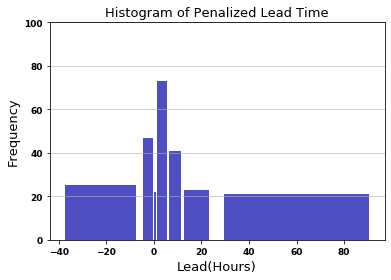

In [11]:
leadTimeAnalysis("CNN_seqs.csv",thresh=0.7)

In [12]:
from tqdm.notebook import tqdm
import tensorflow.keras as ks

# load CNN model from disk
LSTM_model = ks.models.load_model('QuantLSTM.h5')

SIsequences = []
for i in tqdm(range(len(dfOuranno))):
    #print(i,end=" ")
    SIsequences.append(getSIseries(i,dfOuranno,"LSTM",LSTM_model))
    
with open("LSTM_seqs.csv", "w", newline="") as f:
    writer = csv.writer(f)
    writer.writerows(SIsequences)


In [13]:
analyseRDAlarmThresh("LSTM_seqs.csv")

------thres=0.100000----------
Positive : 452
True Positive : 452
Negative : 460
True Negative : 37
Sensitivity :1.0
Specificity :0.08043478260869565
Check threshold effectiveness : 0.08043478260869563
------thres=0.200000----------
Positive : 452
True Positive : 448
Negative : 460
True Negative : 228
Sensitivity :0.9911504424778761
Specificity :0.4956521739130435
Check threshold effectiveness : 0.4868026163909196
------thres=0.300000----------
Positive : 452
True Positive : 444
Negative : 460
True Negative : 355
Sensitivity :0.9823008849557522
Specificity :0.7717391304347826
Check threshold effectiveness : 0.7540400153905348
------thres=0.400000----------
Positive : 452
True Positive : 438
Negative : 460
True Negative : 394
Sensitivity :0.9690265486725663
Specificity :0.8565217391304348
Check threshold effectiveness : 0.8255482878030012
------thres=0.500000----------
Positive : 452
True Positive : 437
Negative : 460
True Negative : 405
Sensitivity :0.9668141592920354
Specificity :0.88

/home/ubuntu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: All-NaN axis encountered


203
268
9.85164203612479
7.103233830845769


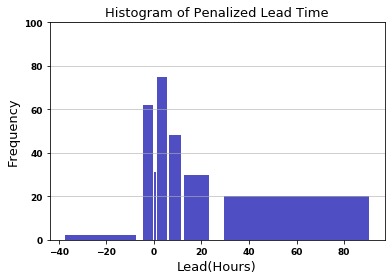

In [14]:
leadTimeAnalysis("LSTM_seqs.csv",thresh=0.7)